In [157]:
import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *
from time import time
import cvxpy as cp

## Testing Approximate Reference

In [247]:
n = 200
p = 5

np.random.seed(9)
X = np.random.normal(size=(n, p))
a = 1
b = 2

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd = 2
noise_sd = 5
y = mu + np.random.normal(size=(n,), scale=sd)
# Create and train the regression tree
reg_tree = RegressionTree(max_depth=3, min_proportion=0,
                          min_samples_split=50, min_bucket=20,)

In [248]:
reg_tree.fit(X, y, sd = noise_sd * sd)

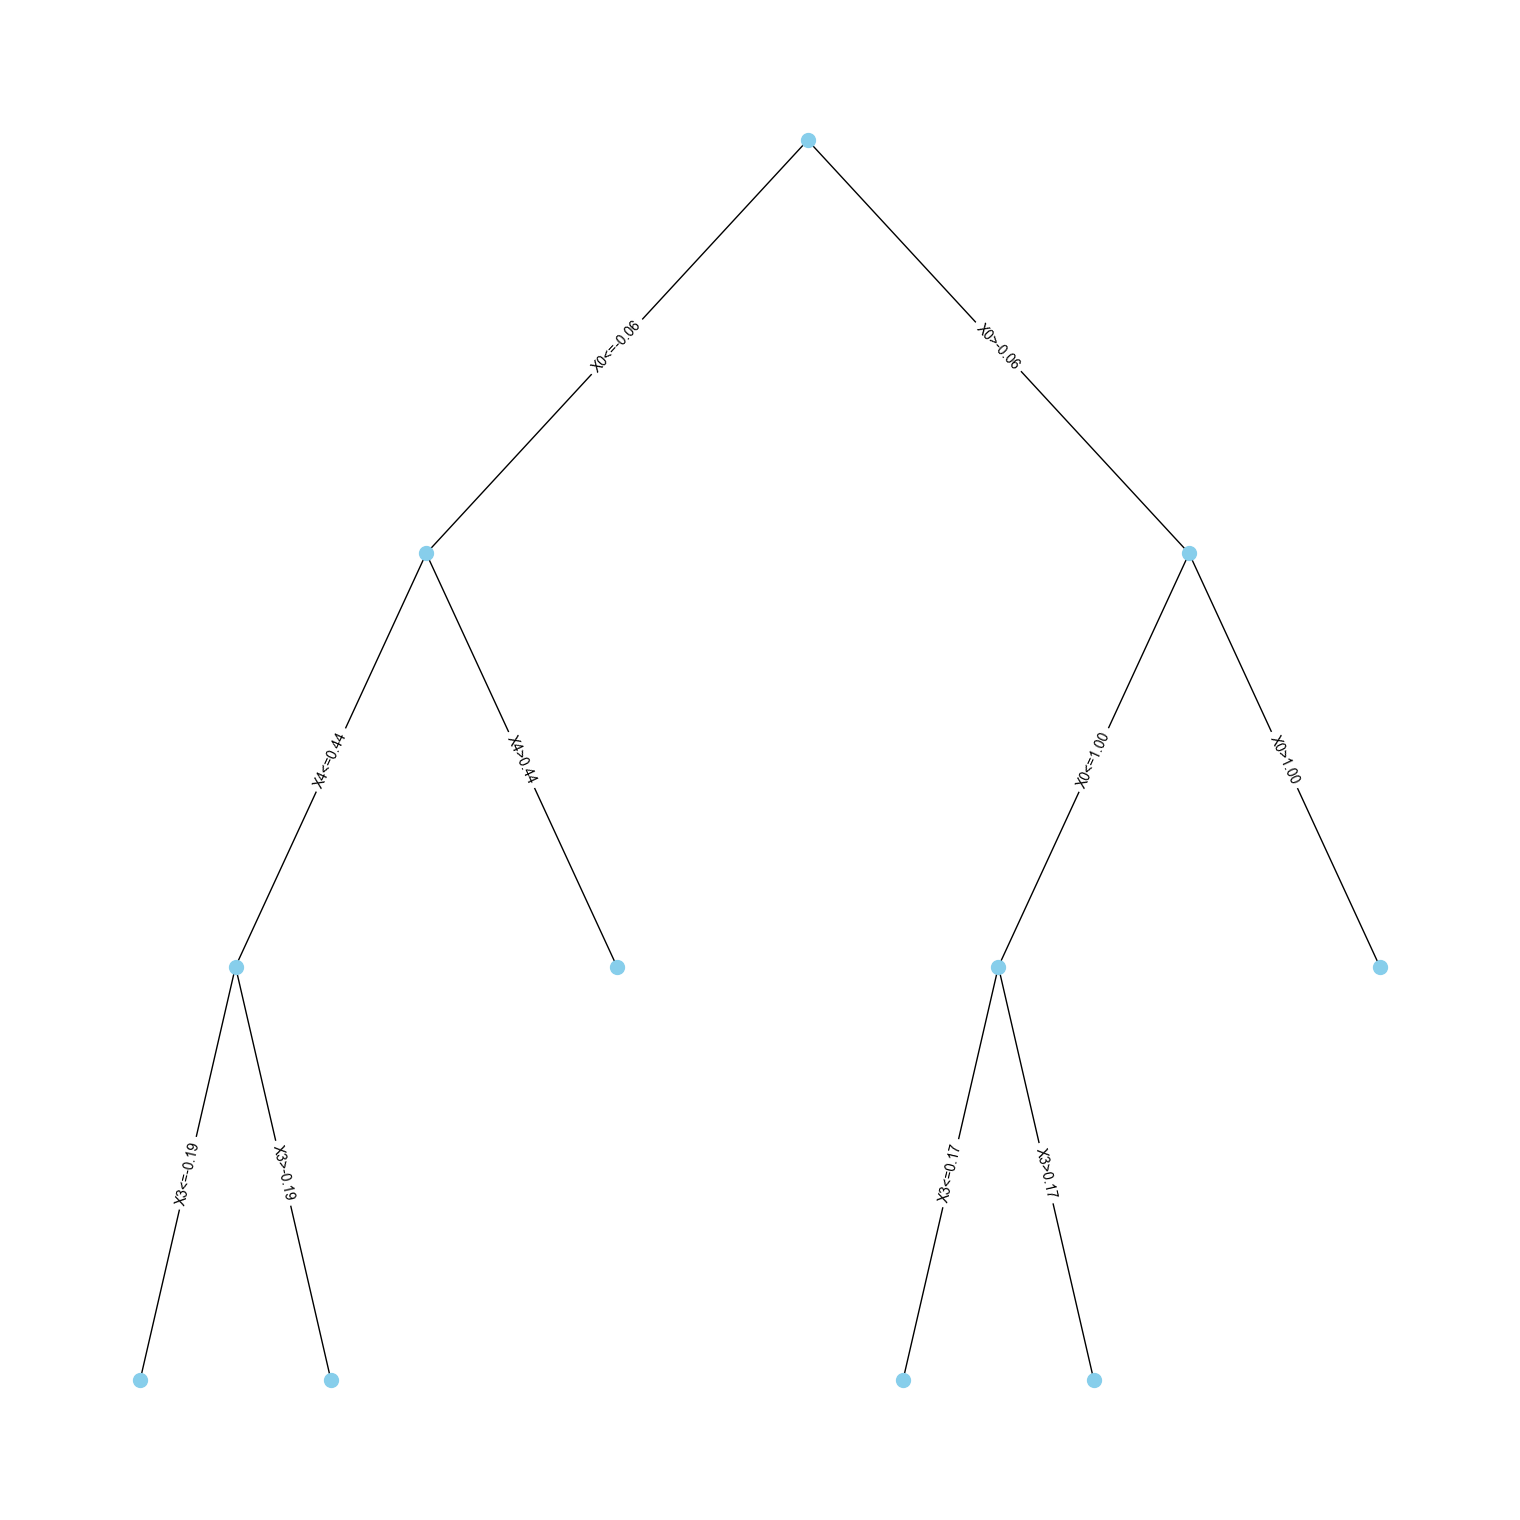

In [249]:
draw_tree(reg_tree.root)

In [250]:
t1 = time()
pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs, marginal = (
    reg_tree.condl_node_inference(node=reg_tree.terminal_nodes[1], 
                                  ngrid=10000,
                                  ncoarse=100,
                                  grid_w_const=3,
                                  reduced_dim=None,
                                  sd=sd, use_cvxpy=True))
t2 = time()
print(t2 - t1)

23.110209941864014


In [251]:
t1 = time()
pval_full, dist_full, contrast_full, norm_contrast_full, obs_tar_full, logW_full, suff_full, sel_probs_full = (
    reg_tree.node_inference(node=reg_tree.terminal_nodes[1], 
                            ngrid=10000,
                            ncoarse=100,
                            grid_w_const=3,
                            sd=sd, use_cvxpy=True))
t2 = time()
print(t2 - t1)

86.6285309791565


In [252]:
print(dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                            alpha=0.1))
print(norm_contrast.dot(mu))

(np.float64(11.970274025247175), np.float64(16.908190194328625))
11.67434463174037


In [253]:
sd_obs_tar = np.linalg.norm(norm_contrast) * sd
print(sd_obs_tar)

1.0


In [254]:
print(dist_full.equal_tailed_interval(observed=norm_contrast_full.dot(y),
                                      alpha=0.1))
print(norm_contrast_full.dot(mu))

(np.float64(9.131056582274413), np.float64(12.431020597158716))
11.67434463174037


In [255]:
obs_tar

np.float64(10.780661062061442)

In [256]:
norm_contrast.dot(y)

np.float64(10.780661062061442)

In [257]:
naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                     null=norm_contrast.dot(mu))
print(naive_pivot)

0.8142543906346218


In [258]:
print(obs_tar)

10.780661062061442


In [259]:
print(norm_contrast.dot(mu))

11.67434463174037


In [260]:
def normalize(x):
    return x/x.sum()

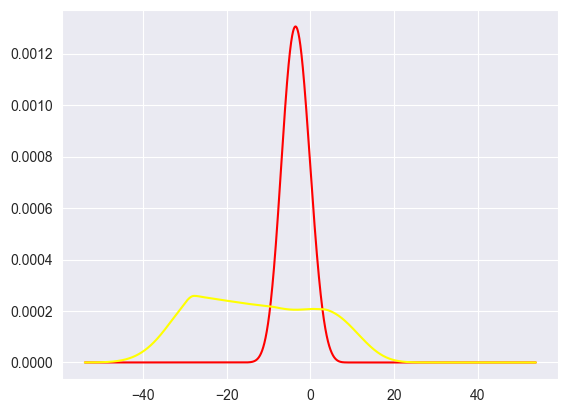

In [261]:
import matplotlib.pyplot as plt

x = np.linspace(-5 * np.abs(obs_tar), 5 * np.abs(obs_tar), 10000)
plt.plot(x, normalize(np.exp(sel_probs - marginal - np.max(sel_probs - marginal))), color="red")
#plt.plot(x, (marginal), color="blue")
#plt.plot(x, normalize(np.exp(sel_probs)), color="green")
plt.plot(x, normalize(np.exp(sel_probs_full)), color="yellow")
#plt.plot(x, normalize(dist.pdf(theta=norm_contrast.dot(mu))), color="blue")
#plt.plot(x, normalize(dist_full.pdf(theta=norm_contrast.dot(mu))), color="blue")
#plt.ylim(-5000, 1000)

In [246]:
sel_probs

array([-127972.84957163, -127879.36077323, -127785.92277655, ...,
       -209384.48654871, -209508.96189407, -209633.47739309])

In [140]:
marginal

array([ -894881.7645062 ,  -894209.35959915,  -893537.3466811 , ...,
       -1438015.8259493 , -1438912.00898744, -1439808.51247689])

In [141]:
np.max(np.exp(sel_probs))

np.float64(3.39286895801514e+74)

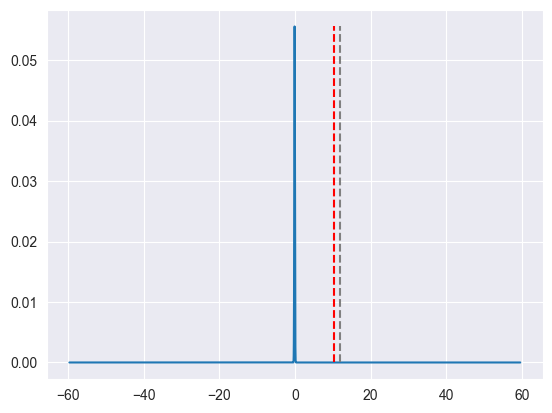

In [142]:
plt.plot(x, dist.pdf(theta=norm_contrast.dot(mu)))
plt.vlines(obs_tar, ymin=0, ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0, 
           ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='red')

In [191]:
dist.pdf(theta=norm_contrast.dot(mu))[x >= obs_tar].sum()

np.float64(0.9614199342973828)

In [192]:
(dist.ccdf(theta=norm_contrast.dot(mu), x=obs_tar))

np.float64(0.9614199342973826)

In [193]:
pval

np.float64(0.9614199342973826)

In [31]:
float("1")

1.0

In [32]:
(x > obs_tar).sum()

np.int64(5000)

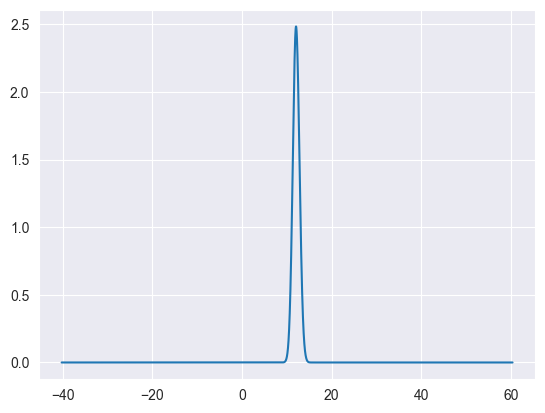

In [33]:
plt.plot(x, np.exp(sel_probs))

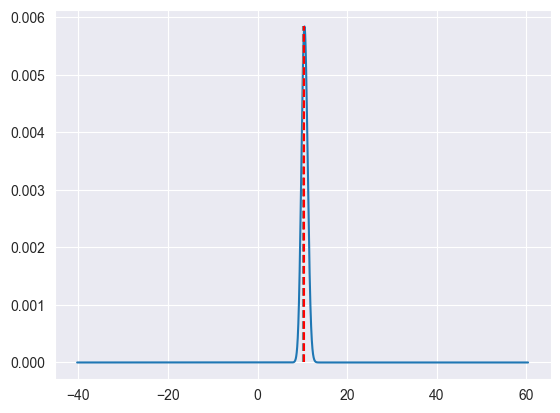

In [34]:
plt.plot(x, dist.pdf(theta=0))
plt.vlines(obs_tar, ymin=0, ymax=np.max(dist.pdf(theta=0)),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0, 
           ymax=np.max(dist.pdf(theta=0)),
           linestyles='--', colors='red')

In [61]:
def root_inference_sim(n = 50, p = 5, a = 0.1, b = 0.1, 
                       sd_y = 1, noise_sd = 1, start=0, end=100):
    pivots = []
    naive_pivots = []
    coverage = []
    naive_coverage = []
    length = []
    naive_length = []
    level=0.1
    for i in range(start, end):
        print(i, "th simulation")
        #np.random.seed(i+1000)
        X = np.random.normal(size=(n, p))

        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        y = mu + np.random.normal(size=(n,), scale=sd_y)
        # Create and train the regression tree
        reg_tree = RegressionTree(min_samples_split=50, max_depth=3,
                                  min_bucket=20, min_proportion=0.)
        reg_tree.fit(X, y, sd = noise_sd * sd_y)
        
        #if not reg_tree.root.left.left:
        #    continue
        """pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs\
            = (reg_tree.condl_split_inference(node=reg_tree.root, ngrid=10000,
                                              ncoarse=100, grid_width=15,
                                              reduced_dim=1, sd=sd_y,
                                              use_cvxpy=True))"""
        
        pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs, marginal \
            = (reg_tree.condl_node_inference(node=reg_tree.terminal_nodes[1],
                                             ngrid=10000,
                                             ncoarse=50,
                                             grid_w_const=1.5,
                                             reduced_dim=None,
                                             sd=sd_y,
                                             use_cvxpy=False))
        """pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs \
            = (reg_tree.node_inference(node=reg_tree.terminal_nodes[0],
                                             ngrid=10000,
                                             ncoarse=50,
                                             grid_w_const=10,
                                             sd=sd_y,
                                             use_cvxpy=True))"""
        
        target = norm_contrast.dot(mu)
        pivot_i = dist.ccdf(theta=target, x=obs_tar)
        pivots.append(pivot_i)
        
        naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                             null=target)
        naive_pivots.append(naive_pivot)
        
        # Naive after tree value
        # Confidence intervals
        naive_CI = [contrast.dot(y) -
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2),
                    contrast.dot(y) +
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2)]
        naive_coverage.append((contrast.dot(mu) >= naive_CI[0] and contrast.dot(mu) <= naive_CI[1]))
        
        selective_CI = (dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                                   alpha=level))
        selective_CI = np.array(selective_CI)
        selective_CI *= np.linalg.norm(contrast) * sd_y
        coverage.append((contrast.dot(mu) >= selective_CI[0] and contrast.dot(mu) <= selective_CI[1]))
        length.append(selective_CI[1] - selective_CI[0])
        naive_length.append(naive_CI[1] - naive_CI[0])
        
    
    return pivots, naive_pivots, coverage, naive_coverage, length, naive_length

In [62]:
t1 = time()
pivots_50, naive_pivots_50, coverage, naive_coverage, length, naive_length \
    = root_inference_sim(start=0, end=100, n=200,
                         sd_y=1, noise_sd=5, 
                         a=1,b=2)
t2 = time()

0 th simulation
1 th simulation
2 th simulation


KeyboardInterrupt: 

(array([19.,  7.,  7.,  7., 13., 10., 11.,  8., 10.,  8.]),
 array([0.00277659, 0.10071356, 0.19865054, 0.29658751, 0.39452449,
        0.49246147, 0.59039844, 0.68833542, 0.78627239, 0.88420937,
        0.98214635]),
 <BarContainer object of 10 artists>)

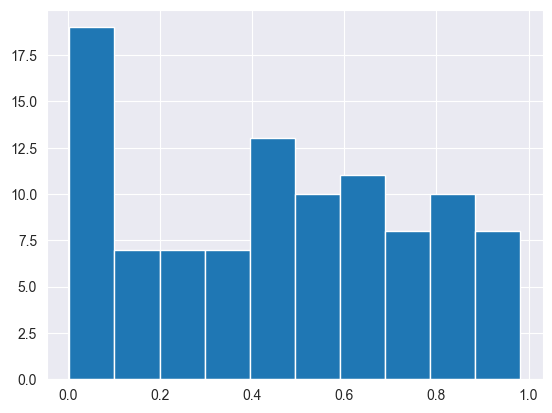

In [49]:
plt.hist(pivots_50, bins=10)

(array([10., 10.,  9.,  6.,  9.,  6., 13., 15., 10., 12.]),
 array([0.00738845, 0.10571321, 0.20403797, 0.30236272, 0.40068748,
        0.49901223, 0.59733699, 0.69566175, 0.7939865 , 0.89231126,
        0.99063601]),
 <BarContainer object of 10 artists>)

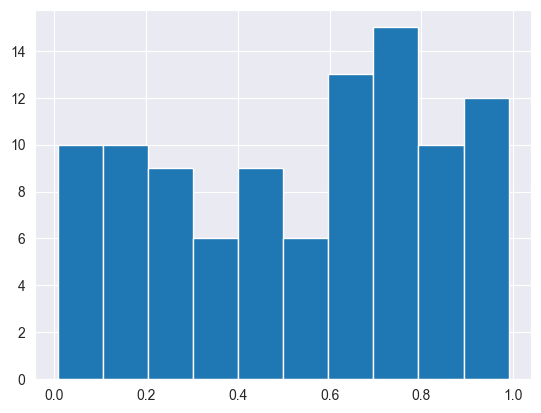

In [50]:
plt.hist(naive_pivots_50, bins=10)

In [51]:
def plot_ecdf(data):
    # Step 2: Sort the data
    data_sorted = np.sort(data)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
    plt.title('Empirical Cumulative Distribution Function')
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_ecdfs(data_list, labels, title=None):
    # Step 2: Sort the data
    sorted_data = []
    for data in data_list:
        data_sorted = np.sort(data)
        sorted_data.append(data_sorted)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    for i, data in enumerate(sorted_data):
        plt.step(data, cdf_values, where='post', 
                 label=labels[i])
    if not title:
        plt.title('Empirical Cumulative Distribution Function')
    else:
        plt.title(title)
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()


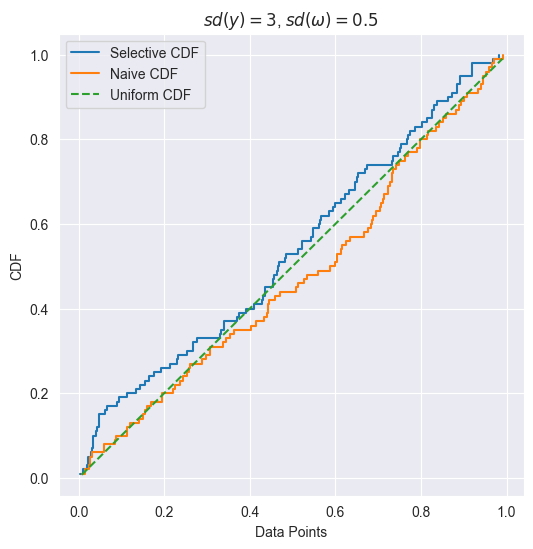

In [52]:
plot_ecdfs([pivots_50, naive_pivots_50], ["Selective CDF", "Naive CDF"],
           title="$sd(y)=3$, $sd(\omega) = 0.5$")

In [53]:
np.mean(coverage)

np.float64(0.83)

In [54]:
np.mean(naive_coverage)

np.float64(0.89)